# DESeq2: Basic Differential Expression (DE) analysis

## Objective: Carry out a basic set of DE analyses using DESeq2 and visualize the results

### Load packages

In [1]:
library(tidyverse)
library(DESeq2)
library(dendextend)
library(RColorBrewer)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”
── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.0     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: S4Vectors

Loading required package: stats4

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, uni

### Load the 2021 pilot dds object from image file

In [2]:
imgdir <- "Data/"

imgfile <- file.path(imgdir, "HIVdemo2021-DDS.RDS")

imgfile

tools::md5sum(imgfile)

dds2021 <- readRDS(imgfile)

[1] "Data//HIVdemo2021-DDS.RDS"

Data//HIVdemo2021-DDS.RDS 
"4ee9180e123d9745a0fa0e371df8cf4a"

### Check dimensions of the two objects

# Inspect object & Slots of an S4 class

Let's has a look at the object we have created.

In [3]:
dds2021

class: DESeqDataSet 
dim: 8340 24 
metadata(1): version
assays(1): counts
rownames(8340): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(22): Label sample_year ... RIN_normal_threshold
  RIN_lowered_threshold

see the class of dds object

In [4]:
class(dds2021)

[1] "DESeqDataSet"
attr(,"package")
[1] "DESeq2"

DESeqDataSet is a S4 object. Recall that a S4 object was taught when introducing bioconductor. Note that S4 objects allow users to wrap up multiple elements into a single variables where each element is called a slot.

In [5]:
slotNames(dds2021)

[1] "design"             "dispersionFunction" "rowRanges"         
[4] "colData"            "assays"             "NAMES"             
[7] "elementMetadata"    "metadata"

The metadata (columnData) is stored in the slot `colData`

In [6]:
colData(dds2021) %>% as.data.frame %>% head(3)

Label       sample_year group enrich_rep RNA_sample_num genotype
1_2019_P_M1 1_2019_P_M1 2019        P     1          1              WT      
2_2019_P_M1 2_2019_P_M1 2019        P     1          2              WT      
3_2019_P_M1 3_2019_P_M1 2019        P     1          3              WT      
            condition libprep_person enrichment_method enrichment_short ⋯
1_2019_P_M1 pH4       C              mRNA              M                ⋯
2_2019_P_M1 pH4       C              mRNA              M                ⋯
3_2019_P_M1 pH4       C              mRNA              M                ⋯
            i5_primer i7_primer library_num bio_replicate Nanodrop_260_280
1_2019_P_M1 i501      i701      1           1             2.14            
2_2019_P_M1 i502      i701      2           2             2.12            
3_2019_P_M1 i503      i701      3           3             2.11            
            Nanodrop_260_230 Nanodrop_concentration_ng_ul
1_2019_P_M1 1.52             293                         
2_2019_P_M1 1.79             290                         
3_2019_P_M1 2.49             302                         
            Bioanalyzer_concentration_ng_ul RIN_normal_threshold
1_2019_P_M1 197                             N/A                 
2_2019_P_M1 225                             N/A                 
3_2019_P_M1 241                             N/A                 
            RIN_lowered_threshold
1_2019_P_M1 9.8                  
2_2019_P_M1 9.9                  
3_2019_P_M1 9.9

The design formula is stored in the slot `design`. The design holds the R formula which expresses how the counts depend on the variables in colData.

In [7]:
design(dds2021)

~condition

The first thing you may want to do is **have a look at the raw counts** you have imported. The `DESeq2::counts` function extracts a matrix of counts (with the genes along the rows and samples along the columns). Let us first verify the dimension of this matrix.

In [8]:
dim(counts(dds2021))

[1] 8340   24

In [9]:
head(counts(dds2021),3)

1_2019_P_M1 2_2019_P_M1 3_2019_P_M1 4_2019_P_M1 5_2019_P_M1
CNAG_00001   0           0           0           0           0        
CNAG_00002 158         204         149         176         161        
CNAG_00003 201         156         161         171         162        
           6_2019_P_M1 7_2019_P_M1 8_2019_P_M1 9_2019_P_M1 10_2019_P_M1 ⋯
CNAG_00001   0           0           0           0           0          ⋯
CNAG_00002 148         172         169         124         119          ⋯
CNAG_00003 103         172         170         175         131          ⋯
           15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 19_2019_P_M1
CNAG_00001   0            0            0            0            0         
CNAG_00002 216          224          234          338          191         
CNAG_00003 197          195          211          201          118         
           20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1
CNAG_00001   0            0            0            0            0         
CNAG_00002 201          192          166          202          235         
CNAG_00003 133          109          113          154          169

This slot returns gene specific information (it will be populated later)

In [10]:
dispersionFunction(dds2021)

function () 
NULL
<bytecode: 0x55cb04320f98>

Get size factors

In [11]:
sizeFactors(dds2021)

NULL

# Estimate Size Factors and Dispersion Parameters

You recall that DESeq requires that  we have estimates for sample specific size factors and gene specific dispersion factors. More specifically, recall that DESeq models the count $K_{ij}$ (gene $i$, sample $j$) as negative binomial with mean $\mu_{ij}$ and dispersion parameter $\alpha_i$. Here $\mu_{ij}=s_j q_{ij}$ where $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} x_j$. Here $s_j$ is the sample $j$ specific size factor.

**Summarize of notation**
- $K_{ij}$ denotes the observed **number of reads** mapped to gene $i$ for sample $j$
- $K_{ij}$ follows a **negative binomial distribution** with
    - **Mean** $\mu_{ij}$
    - **Dispersion parameter** $\alpha_i$
- Modelling
    - $K_{ij} \sim NB(\mu_{ij}, \alpha_i)$
    - $\mu_{ij} = s_{j}q_{ij}$
        - $s_j$ is sample $j$ specific normalization constant
    - $\log_2(q_{ij}) = \beta_{0i} + \beta_{1i} x_j$
        - $x_j=0$ if condition = ph4 or 
        - $x_j=1$ if condition = ph8

## 01 Size Factors
 We begin by estimating the size factors $s_1,\ldots,s_n$:

In [12]:
dds2021 <- estimateSizeFactors(dds2021)

Now, compare the dds object to that of before applying the estimateSizeFactors() function. What has changed? What remains unchanged?

In [13]:
dds2021

class: DESeqDataSet 
dim: 8340 24 
metadata(1): version
assays(1): counts
rownames(8340): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Note that there is a **sizeFactor** added to **colData**. Let's look at it more carefully

```
> dds # (before estimateSizeFactors)
class: DESeqDataSet 
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(22): Label sample_year ... RIN_normal_threshold
  RIN_lowered_threshold

> dds # (after estimateSizeFactors)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

You can also get the size factors directly

In [14]:
sizeFactors(dds2021)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
   1.5916393    1.6587110    1.5128946    1.4196686    1.4373847    1.2371000 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
   1.4014829    1.4421725    1.1744409    1.0763647    1.0421627    0.9712383 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
   0.7709868    0.7523820    0.7176796    0.8978403    0.8936416    0.9316181 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
   0.7494357    0.7755715    0.5838325    0.6343998    0.7551861    0.8088364

 It is preferable to limit the number of decimal places. Next show the size factors rounded to 3 decimal places

In [15]:
round(sizeFactors(dds2021),3)

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
       1.592        1.659        1.513        1.420        1.437        1.237 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
       1.401        1.442        1.174        1.076        1.042        0.971 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
       0.771        0.752        0.718        0.898        0.894        0.932 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
       0.749        0.776        0.584        0.634        0.755        0.809

Summarize size factors

In [16]:
summary(sizeFactors(dds2021))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.5838  0.7670  0.9514  1.0515  1.4060  1.6587 

Now that the size factors have been estimated, we can get "normalized" counts (DESeq2 normalizes against size factor)

In [17]:
# original counts for samples 1 and 3
counts(dds2021)[1:5,c(1,3)]

1_2019_P_M1 3_2019_P_M1
CNAG_00001   0           0        
CNAG_00002 158         149        
CNAG_00003 201         161        
CNAG_00004 904         941        
CNAG_00005  22          12

In [18]:
# Size factors for samples 1 and 3

sizeFactors(dds2021)[c(1,3)]

1_2019_P_M1 3_2019_P_M1 
   1.591639    1.512895

In [19]:
# normalized count for samples 1 and 3
counts(dds2021, normalize = TRUE)[1:5, c(1,3)]

1_2019_P_M1 3_2019_P_M1
CNAG_00001   0.00000     0.000000 
CNAG_00002  99.26872    98.486705 
CNAG_00003 126.28489   106.418520 
CNAG_00004 567.96787   621.986506 
CNAG_00005  13.82223     7.931815

In [20]:
# normalized manually using size factors for sample 1
counts(dds2021)[1:5, 1] / sizeFactors(dds2021)[1]

CNAG_00001 CNAG_00002 CNAG_00003 CNAG_00004 CNAG_00005 
   0.00000   99.26872  126.28489  567.96787   13.82223

In [21]:
# normalized manually using size factors for sample 3
counts(dds2021)[1:5, 3] / sizeFactors(dds2021)[3]

CNAG_00001 CNAG_00002 CNAG_00003 CNAG_00004 CNAG_00005 
  0.000000  98.486705 106.418520 621.986506   7.931815

How do you get the raw counts for gene  "GeneID: CNAG_05845"?

In [22]:
counts(dds2021, normalize = FALSE)["CNAG_05845",]

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
        2791         2461         2112         2167         2215         2057 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
        2079         2014         1893         1649         1694         1645 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
        1256         1204         1130         1393         1548         1419 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
        1366         1396         1093         1074         1384         1449

In [23]:
counts(dds2021, normalize = TRUE)["CNAG_05845",]

1_2019_P_M1  2_2019_P_M1  3_2019_P_M1  4_2019_P_M1  5_2019_P_M1  6_2019_P_M1 
    1753.538     1483.682     1395.999     1526.413     1540.993     1662.760 
 7_2019_P_M1  8_2019_P_M1  9_2019_P_M1 10_2019_P_M1 11_2019_P_M1 12_2019_P_M1 
    1483.429     1396.504     1611.831     1532.009     1625.466     1693.714 
13_2019_P_M1 14_2019_P_M1 15_2019_P_M1 16_2019_P_M1 17_2019_P_M1 18_2019_P_M1 
    1629.081     1600.251     1574.519     1551.501     1732.238     1523.156 
19_2019_P_M1 20_2019_P_M1 21_2019_P_M1 22_2019_P_M1 23_2019_P_M1 24_2019_P_M1 
    1822.705     1799.963     1872.112     1692.939     1832.661     1791.462

## 02 Dispersion Parameters
Next, we get the dispersion factors $\alpha_1,\ldots,\alpha_{m}$

In [24]:
dds2021 <- estimateDispersions(dds2021)

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates



Now inspect the dds object again and note that the rowRanges slot has extra information ("metadata column names(0):" before versus "column names(9): baseMean baseVar ... dispOutlier dispMAP")
- before: 
    - `metadata column names(0):`
- after:  
    - `column names(9): baseMean baseVar ...`

In [25]:
dds2021

class: DESeqDataSet 
dim: 8340 24 
metadata(1): version
assays(2): counts mu
rownames(8340): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor

Can you notice the difference?
```
> dds (before dispersion)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(1): counts
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(0):
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor
  
> dds (after dispersion)
class: DESeqDataSet 
dim: 8499 24 
metadata(1): version
assays(2): counts mu
rownames(8499): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(10): baseMean baseVar ... dispOutlier dispMAP
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(23): Label sample_year ... RIN_lowered_threshold
  sizeFactor
```

Note that the dispersionfunction slot is now populated

In [26]:
dispersionFunction(dds2021)

function (q) 
coefs[1] + coefs[2]/q
<bytecode: 0x55cb1231a8a0>
<environment: 0x55cb123170c8>
attr(,"coefficients")
asymptDisp  extraPois 
0.02232377 1.35100874 
attr(,"fitType")
[1] "parametric"
attr(,"varLogDispEsts")
[1] 0.9835306
attr(,"dispPriorVar")
[1] 0.8883643

We can extract the gene specific dispersion factors using dispersions(). Note that there will be one number per gene. We look at the first four genes (rounded to 4 decimal places)

In [27]:
alphas <- dispersions(dds2021)

Verify that the number of dispersion factors equals the number of genes

In [28]:
# number of disperion factors
length(alphas)

[1] 8340

In [29]:
round(alphas[1:4], 4)

[1]     NA 0.0137 0.0237 0.0046

Extract the metadata using mcols() for the first four genes

| Terms       | Description                                   |
|-------------|-----------------------------------------------|
| baseMean    |     mean of normalized counts for all samples |
| baseVar     | variance of normalized counts for all samples |
| allZero     |                all counts for a gene are zero |
| dispGeneEst |             gene-wise estimates of dispersion |
| dispFit     |                   fitted values of dispersion |
| dispersion  |                  final estimate of dispersion |
| dispIter    |                          number of iterations |
| dispOut     |                 dispersion flagged as outlier |
| dispMAP     |                 maximum a posteriori estimate |


In [30]:
mcols(dds2021)[1:4,] %>% as.data.frame

baseMean baseVar  allZero dispGeneEst dispGeneIter dispFit   
CNAG_00001   0.0000    0.000  TRUE            NA NA                   NA
CNAG_00002 192.4564 8133.183 FALSE   0.011522838  9           0.02934358
CNAG_00003 164.9908 3089.489 FALSE   0.022861239  7           0.03051215
CNAG_00004 571.0547 1819.185 FALSE   0.003114207  7           0.02468958
           dispersion  dispIter dispOutlier dispMAP    
CNAG_00001          NA NA          NA                NA
CNAG_00002 0.013655751  9       FALSE       0.013655751
CNAG_00003 0.023708628  7       FALSE       0.023708628
CNAG_00004 0.004623136  8       FALSE       0.004623136

Summarize the dispersion factors using a box plot (may want to log transform)

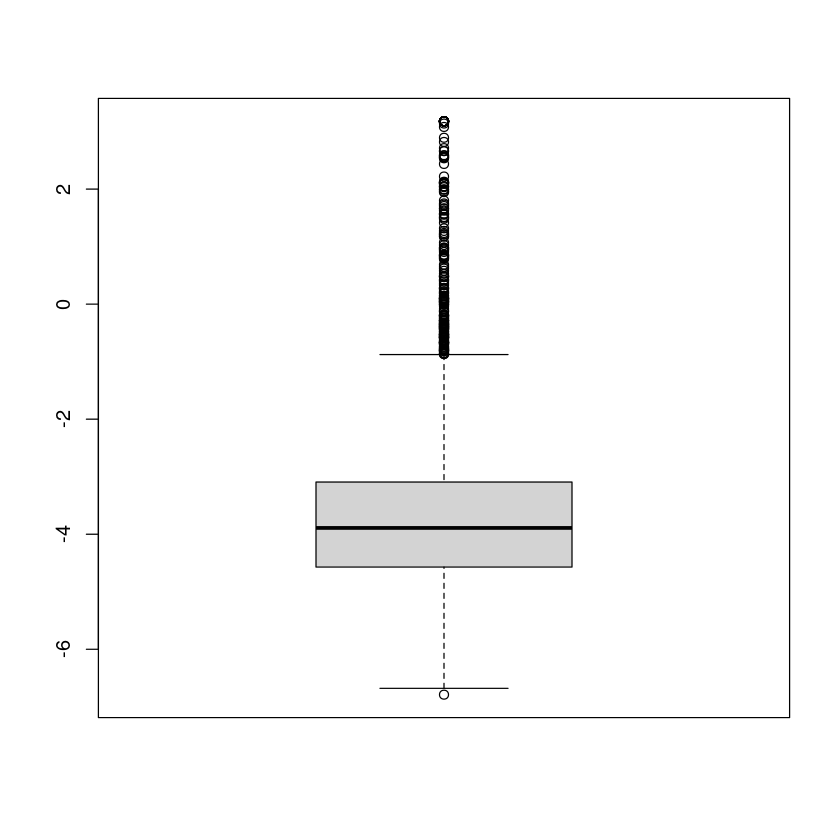

In [31]:
boxplot(log(dispersions(dds2021)))

# Differential Expression Analysis
We can now conduct a differential expression analysis using the DESeq() function. Keep in mind that to get to this step, we first estimated the size factors and then the dispersion parameters.

In [32]:
### Carry out DE analysis
ddsDE <- DESeq(dds2021)

using pre-existing size factors

estimating dispersions

found already estimated dispersions, replacing these

gene-wise dispersion estimates

mean-dispersion relationship

final dispersion estimates

fitting model and testing

-- replacing outliers and refitting for 1 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)

estimating dispersions

fitting model and testing



In [33]:
### Look at object
ddsDE

class: DESeqDataSet 
dim: 8340 24 
metadata(1): version
assays(6): counts mu ... replaceCounts replaceCooks
rownames(8340): CNAG_00001 CNAG_00002 ... large_MTrRNA small_MTrRNA
rowData names(23): baseMean baseVar ... maxCooks replace
colnames(24): 1_2019_P_M1 2_2019_P_M1 ... 23_2019_P_M1 24_2019_P_M1
colData names(24): Label sample_year ... sizeFactor replaceable

In [34]:
### Look at some of the results
results(ddsDE)

log2 fold change (MLE): condition pH8 vs pH4 
Wald test p-value: condition pH8 vs pH4 
DataFrame with 8340 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
CNAG_00001       0.0000             NA        NA        NA          NA
CNAG_00002     192.4564      1.3426839 0.0823290  16.30875 8.55244e-60
CNAG_00003     164.9908      0.8352909 0.1021026   8.18090 2.81737e-16
CNAG_00004     571.0547      0.0864961 0.0472251   1.83157 6.70154e-02
CNAG_00005      28.7106      1.2786070 0.2069447   6.17850 6.47152e-10
...                 ...            ...       ...       ...         ...
CNAG_13205      3.59848      0.0974385  0.417744   0.23325 8.15568e-01
CNAG_13206    212.78289     -1.7593016  0.236957  -7.42457 1.13148e-13
CNAG_13207      4.61871     -0.8223263  0.346934  -2.37027 1.77751e-02
large_MTrRNA 5333.97356      0.9311099  0.155150   6.00137 1.95658e-09
small_MTrRNA 1705.7547

Note that currently, the model we have is an additive model, which does not include the interaction term of `Media` and `Strain`

### Look at some of the results (tidy version)


In [35]:
results(ddsDE, tidy = TRUE)

row          baseMean     log2FoldChange lfcSE      stat       
1    CNAG_00001      0.00000            NA            NA          NA
2    CNAG_00002    192.45638    1.34268391    0.08232905  16.3087504
3    CNAG_00003    164.99082    0.83529087    0.10210259   8.1808978
4    CNAG_00004    571.05465    0.08649609    0.04722509   1.8315708
5    CNAG_00005     28.71062    1.27860704    0.20694471   6.1784958
6    CNAG_00006   3147.39964   -0.13774241    0.05669872  -2.4293743
7    CNAG_00007   1484.87545   -0.72062267    0.09486532  -7.5962713
8    CNAG_00008    938.01932   -0.07880467    0.04758123  -1.6562134
9    CNAG_00009    305.19881   -0.54598735    0.10623081  -5.1396327
10   CNAG_00010    989.04227    0.52479611    0.08803766   5.9610410
11   CNAG_00011   1001.75238   -2.14895366    0.08675271 -24.7710268
12   CNAG_00012    773.99385    0.16298241    0.07051463   2.3113276
13   CNAG_00013    485.75319   -0.72300462    0.07993079  -9.0453831
14   CNAG_00014    180.53988   -0.29458827    0.06925426  -4.2537205
15   CNAG_00015    318.87538   -0.33599308    0.11434287  -2.9384699
16   CNAG_00016    901.25567    0.32140738    0.05773436   5.5670030
17   CNAG_00017    184.65031    0.31786984    0.09919846   3.2043827
18   CNAG_00018    876.12980    0.15534402    0.03888933   3.9945151
19   CNAG_00019   1208.90542    0.74614513    0.05462184  13.6601976
20   CNAG_00020    968.39030   -0.46518458    0.07063038  -6.5861827
21   CNAG_00021    539.92676    0.01367620    0.08974401   0.1523913
22   CNAG_00022    746.84601    0.01807429    0.06212305   0.2909434
23   CNAG_00023    278.87826    0.76707949    0.37458519   2.0478105
24   CNAG_00024   7703.04647    0.99443687    0.04888977  20.3403866
25   CNAG_00025   2021.99612    0.89200257    0.09837092   9.0677463
26   CNAG_00026   2237.77134    0.16652839    0.07633715   2.1814855
27   CNAG_00027    425.60765   -0.92951022    0.06722912 -13.8260065
28   CNAG_00028    381.48552   -0.82017313    0.06392230 -12.8307818
29   CNAG_00029     52.66523   -3.31625743    0.16696976 -19.8614256
30   CNAG_00030     76.57328   -1.13388063    0.14543963  -7.7962286
⋮    ⋮            ⋮            ⋮              ⋮          ⋮          
8311 CNAG_13180      6.5721212  0.60732313    0.49683428  1.2223857 
8312 CNAG_13181    149.5209076  0.66617509    0.13615616  4.8927283 
8313 CNAG_13182      4.1021502  1.76872005    0.49677974  3.5603707 
8314 CNAG_13183     15.5841647  0.34741003    0.18459685  1.8819933 
8315 CNAG_13184      2.4523900  0.50592237    0.47395483  1.0674485 
8316 CNAG_13185     10.0778672 -0.48443456    0.39553520 -1.2247571 
8317 CNAG_13186    653.4778310  1.83279824    0.05975491 30.6719294 
8318 CNAG_13187     21.9319951 -0.38774210    0.17880595 -2.1685078 
8319 CNAG_13188    812.5594275  0.83116821    0.12861722  6.4623402 
8320 CNAG_13189     22.6019699 -1.11347994    0.20060033 -5.5507384 
8321 CNAG_13190     13.7227265  1.13366919    0.22677877  4.9990093 
8322 CNAG_13191     20.1416928  1.40784652    0.20219259  6.9628987 
8323 CNAG_13192     54.1000771  0.02391460    0.17610806  0.1357950 
8324 CNAG_13193      0.5335838 -0.91509994    1.02570016 -0.8921710 
8325 CNAG_13194     46.2142350 -0.82368330    0.19877260 -4.1438474 
8326 CNAG_13195      8.8601880 -2.45031407    0.34244420 -7.1553675 
8327 CNAG_13196    175.8096559  1.69598398    0.09731248 17.4282266 
8328 CNAG_13197    133.2914027 -1.30449391    0.14501174 -8.9957812 
8329 CNAG_13198    197.0447591  0.61340412    0.14131552  4.3406707 
8330 CNAG_13199     50.1576264 -1.13923987    0.27491777 -4.1439295 
8331 CNAG_13200    239.6453364  3.91401525    0.18617924 21.0228342 
8332 CNAG_13201     76.6325633  1.98195729    0.21316445  9.2977852 
8333 CNAG_13202     52.5442471  0.12419011    0.15478004  0.8023651 
8334 CNAG_13203    210.4883236  0.64501116    0.07294813  8.8420518 
8335 CNAG_13204   1015.3915767 -0.68602328    0.09622362 -7.1294687 
8336 CNAG_13205      3.5984827  0.09743854    0.41774359  0.2332496 
833

We can get the results for the differential expression analysis using results(). Here, we can compare two group of samples specified by the contrast. (If not, the default contrast would be the last term in your additive model `design(dds)`).

In [36]:
# DE with respect to condition
myres_condition4v8 <- results(ddsDE, contrast = c("condition", "pH4", "pH8"))
myres_condition4v8

log2 fold change (MLE): condition pH4 vs pH8 
Wald test p-value: condition pH4 vs pH8 
DataFrame with 8340 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
CNAG_00001       0.0000             NA        NA        NA          NA
CNAG_00002     192.4564     -1.3426839 0.0823290 -16.30875 8.55244e-60
CNAG_00003     164.9908     -0.8352909 0.1021026  -8.18090 2.81737e-16
CNAG_00004     571.0547     -0.0864961 0.0472251  -1.83157 6.70154e-02
CNAG_00005      28.7106     -1.2786070 0.2069447  -6.17850 6.47152e-10
...                 ...            ...       ...       ...         ...
CNAG_13205      3.59848     -0.0974385  0.417744  -0.23325 8.15568e-01
CNAG_13206    212.78289      1.7593016  0.236957   7.42457 1.13148e-13
CNAG_13207      4.61871      0.8223263  0.346934   2.37027 1.77751e-02
large_MTrRNA 5333.97356     -0.9311099  0.155150  -6.00137 1.95658e-09
small_MTrRNA 1705.7547

In [37]:
# DE with respect to condition (flip order)
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"))
myres_condition8v4

log2 fold change (MLE): condition pH8 vs pH4 
Wald test p-value: condition pH8 vs pH4 
DataFrame with 8340 rows and 6 columns
               baseMean log2FoldChange     lfcSE      stat      pvalue
              <numeric>      <numeric> <numeric> <numeric>   <numeric>
CNAG_00001       0.0000             NA        NA        NA          NA
CNAG_00002     192.4564      1.3426839 0.0823290  16.30875 8.55244e-60
CNAG_00003     164.9908      0.8352909 0.1021026   8.18090 2.81737e-16
CNAG_00004     571.0547      0.0864961 0.0472251   1.83157 6.70154e-02
CNAG_00005      28.7106      1.2786070 0.2069447   6.17850 6.47152e-10
...                 ...            ...       ...       ...         ...
CNAG_13205      3.59848      0.0974385  0.417744   0.23325 8.15568e-01
CNAG_13206    212.78289     -1.7593016  0.236957  -7.42457 1.13148e-13
CNAG_13207      4.61871     -0.8223263  0.346934  -2.37027 1.77751e-02
large_MTrRNA 5333.97356      0.9311099  0.155150   6.00137 1.95658e-09
small_MTrRNA 1705.7547

Let's look at the results for the first four genes

In [38]:
### Tidy the results
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)
myres_condition8v4

row          baseMean     log2FoldChange lfcSE      stat       
1    CNAG_00001      0.00000            NA            NA          NA
2    CNAG_00002    192.45638    1.34268391    0.08232905  16.3087504
3    CNAG_00003    164.99082    0.83529087    0.10210259   8.1808978
4    CNAG_00004    571.05465    0.08649609    0.04722509   1.8315708
5    CNAG_00005     28.71062    1.27860704    0.20694471   6.1784958
6    CNAG_00006   3147.39964   -0.13774241    0.05669872  -2.4293743
7    CNAG_00007   1484.87545   -0.72062267    0.09486532  -7.5962713
8    CNAG_00008    938.01932   -0.07880467    0.04758123  -1.6562134
9    CNAG_00009    305.19881   -0.54598735    0.10623081  -5.1396327
10   CNAG_00010    989.04227    0.52479611    0.08803766   5.9610410
11   CNAG_00011   1001.75238   -2.14895366    0.08675271 -24.7710268
12   CNAG_00012    773.99385    0.16298241    0.07051463   2.3113276
13   CNAG_00013    485.75319   -0.72300462    0.07993079  -9.0453831
14   CNAG_00014    180.53988   -0.29458827    0.06925426  -4.2537205
15   CNAG_00015    318.87538   -0.33599308    0.11434287  -2.9384699
16   CNAG_00016    901.25567    0.32140738    0.05773436   5.5670030
17   CNAG_00017    184.65031    0.31786984    0.09919846   3.2043827
18   CNAG_00018    876.12980    0.15534402    0.03888933   3.9945151
19   CNAG_00019   1208.90542    0.74614513    0.05462184  13.6601976
20   CNAG_00020    968.39030   -0.46518458    0.07063038  -6.5861827
21   CNAG_00021    539.92676    0.01367620    0.08974401   0.1523913
22   CNAG_00022    746.84601    0.01807429    0.06212305   0.2909434
23   CNAG_00023    278.87826    0.76707949    0.37458519   2.0478105
24   CNAG_00024   7703.04647    0.99443687    0.04888977  20.3403866
25   CNAG_00025   2021.99612    0.89200257    0.09837092   9.0677463
26   CNAG_00026   2237.77134    0.16652839    0.07633715   2.1814855
27   CNAG_00027    425.60765   -0.92951022    0.06722912 -13.8260065
28   CNAG_00028    381.48552   -0.82017313    0.06392230 -12.8307818
29   CNAG_00029     52.66523   -3.31625743    0.16696976 -19.8614256
30   CNAG_00030     76.57328   -1.13388063    0.14543963  -7.7962286
⋮    ⋮            ⋮            ⋮              ⋮          ⋮          
8311 CNAG_13180      6.5721212  0.60732313    0.49683428  1.2223857 
8312 CNAG_13181    149.5209076  0.66617509    0.13615616  4.8927283 
8313 CNAG_13182      4.1021502  1.76872005    0.49677974  3.5603707 
8314 CNAG_13183     15.5841647  0.34741003    0.18459685  1.8819933 
8315 CNAG_13184      2.4523900  0.50592237    0.47395483  1.0674485 
8316 CNAG_13185     10.0778672 -0.48443456    0.39553520 -1.2247571 
8317 CNAG_13186    653.4778310  1.83279824    0.05975491 30.6719294 
8318 CNAG_13187     21.9319951 -0.38774210    0.17880595 -2.1685078 
8319 CNAG_13188    812.5594275  0.83116821    0.12861722  6.4623402 
8320 CNAG_13189     22.6019699 -1.11347994    0.20060033 -5.5507384 
8321 CNAG_13190     13.7227265  1.13366919    0.22677877  4.9990093 
8322 CNAG_13191     20.1416928  1.40784652    0.20219259  6.9628987 
8323 CNAG_13192     54.1000771  0.02391460    0.17610806  0.1357950 
8324 CNAG_13193      0.5335838 -0.91509994    1.02570016 -0.8921710 
8325 CNAG_13194     46.2142350 -0.82368330    0.19877260 -4.1438474 
8326 CNAG_13195      8.8601880 -2.45031407    0.34244420 -7.1553675 
8327 CNAG_13196    175.8096559  1.69598398    0.09731248 17.4282266 
8328 CNAG_13197    133.2914027 -1.30449391    0.14501174 -8.9957812 
8329 CNAG_13198    197.0447591  0.61340412    0.14131552  4.3406707 
8330 CNAG_13199     50.1576264 -1.13923987    0.27491777 -4.1439295 
8331 CNAG_13200    239.6453364  3.91401525    0.18617924 21.0228342 
8332 CNAG_13201     76.6325633  1.98195729    0.21316445  9.2977852 
8333 CNAG_13202     52.5442471  0.12419011    0.15478004  0.8023651 
8334 CNAG_13203    210.4883236  0.64501116    0.07294813  8.8420518 
8335 CNAG_13204   1015.3915767 -0.68602328    0.09622362 -7.1294687 
8336 CNAG_13205      3.5984827  0.09743854    0.41774359  0.2332496 
833

In [39]:
### Tidy the results for DE with respect to condition
### Results are sorted in ascending order by adjusted p-value
### Here ph4 is the reference level
### log2FC > 0 suggests that higher pH (pH8) is associated with increased expression
### log2FC < 0 suggests that higher pH (pH8) is associated with lower expression
myres_condition8v4 <- results(ddsDE, contrast = c("condition", "pH8", "pH4"), tidy = TRUE)

myres_condition8v4 %>% 
    dplyr::arrange(dplyr::desc(-padj)) %>% 
        head(10)

row        baseMean   log2FoldChange lfcSE      stat      pvalue padj
1  CNAG_00309   539.1312 -3.335980      0.08607209 -38.75798 0      0   
2  CNAG_00409  1093.4775 -5.033798      0.11159621 -45.10725 0      0   
3  CNAG_00531 15371.8856  3.554864      0.06902882  51.49826 0      0   
4  CNAG_00601   506.4752  4.656064      0.10334692  45.05276 0      0   
5  CNAG_01272 49334.5209  1.960477      0.04603231  42.58916 0      0   
6  CNAG_01275  2534.1015  2.270298      0.05553256  40.88228 0      0   
7  CNAG_01713  9652.4535  2.015050      0.05354787  37.63081 0      0   
8  CNAG_02327   719.3513 -3.190612      0.06232939 -51.18952 0      0   
9  CNAG_02655  5088.3692  1.907820      0.04895295  38.97252 0      0   
10 CNAG_02681  1487.9842  2.041771      0.04545085  44.92261 0      0

### Visualize DE effect

Looking at the results for these two genes: 

* The estimated log2FC for CNAG_00275 is negative. We will verify visually that ph8, compared to pH4,  is associated with lower expression

* The estimated log2FC for CNAG_00531 is positive. We will verify visually that ph8, compared to pH4, is associated with higher expression


In [40]:
results(ddsDE, tidy = TRUE) %>%
    dplyr::filter(row %in% c("CNAG_00275","CNAG_00531"))

row        baseMean  log2FoldChange lfcSE      stat      pvalue       
1 CNAG_00275  1072.922 -4.010616      0.12187661 -32.90718 1.734969e-237
2 CNAG_00531 15371.886  3.554864      0.06902882  51.49826  0.000000e+00
  padj         
1 3.448356e-235
2  0.000000e+00

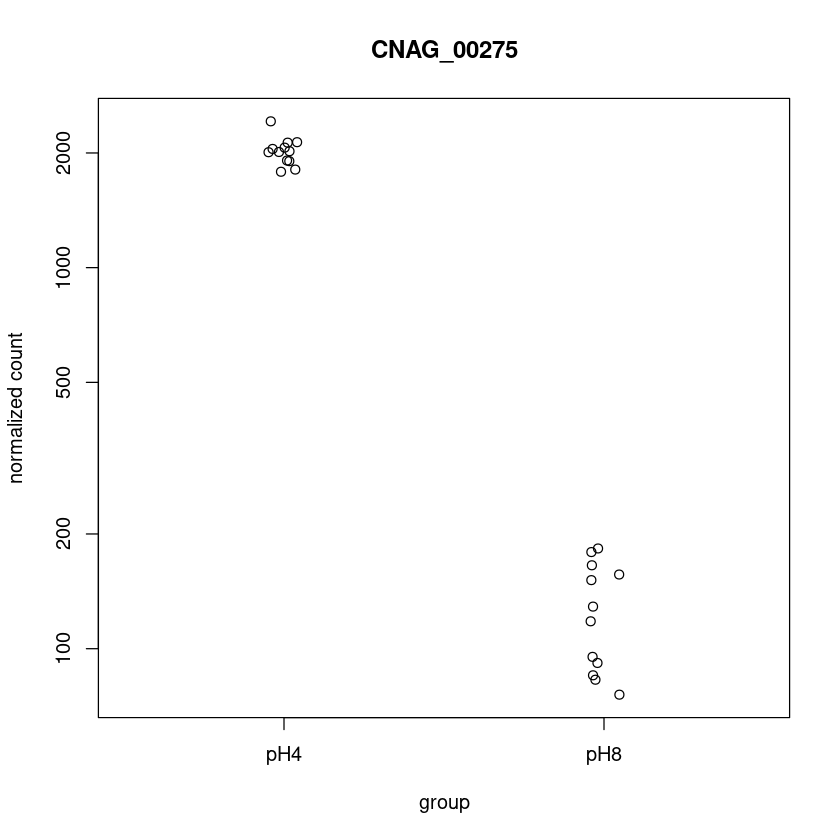

In [41]:
### This dot plot verify visually that exposure to ph8, compared to pH4,  is associated with lower expression
plotCounts(dds2021, "CNAG_00275", intgroup = "condition")

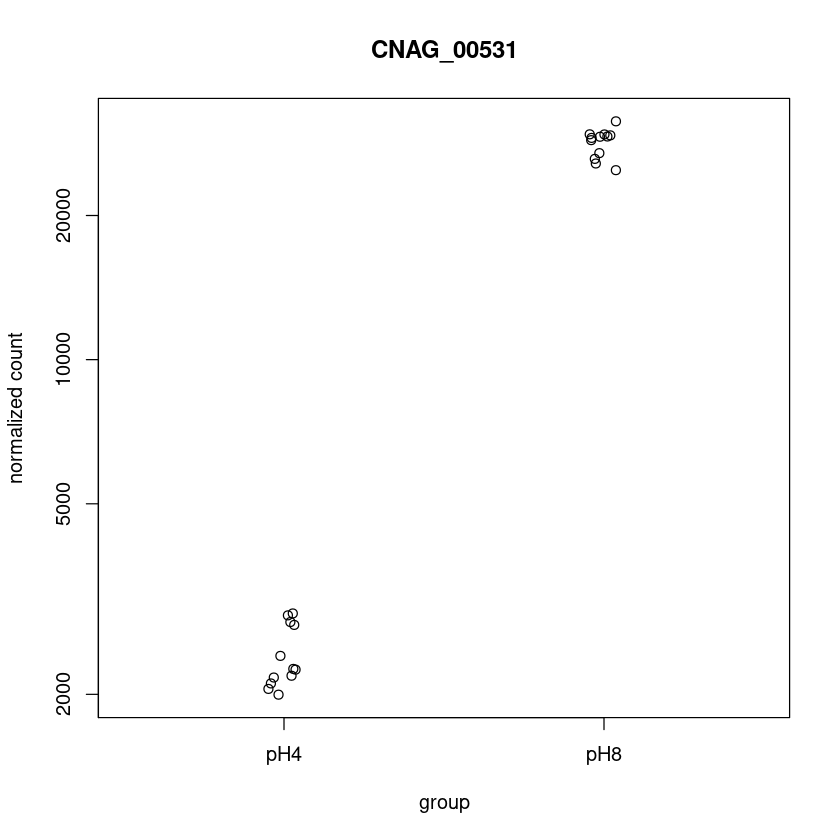

In [42]:
### This dot plot verify visually that exposure to ph8, compared to pH4,  is associated with higher expression
plotCounts(dds2021, "CNAG_00531", intgroup = "condition")

Volcano plot

Warning message:
“Removed 191 rows containing missing values (geom_point).”


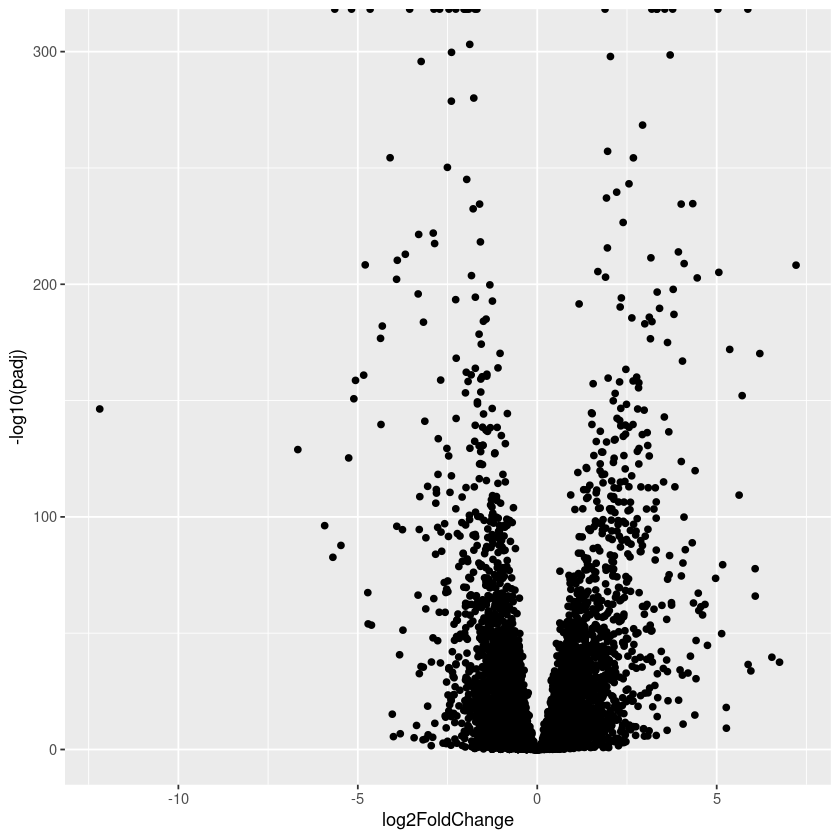

In [43]:
### Volcano plot for con effect
ggplot(results(ddsDE, contrast = c("condition", "pH4", "pH8"), tidy = TRUE), 
       aes(x = log2FoldChange, y = -log10(padj))) + geom_point()

In [44]:
sessionInfo()

R version 4.0.4 (2021-02-15)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] RColorBrewer_1.1-2          dendextend_1.14.0          
 [3] DESeq2_1.30.1               SummarizedExperiment_1.20.0
 [5] Biobase_2.50.0              MatrixGenerics_1.2.1       
 [7] matrixStats_0.58.0          GenomicRanges_